# convolutional VAE

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
% matplotlib inline

## Set Hyperparameter

In [2]:
batch_size=64
learning_rate=0.003
num_epoch=2
leak=0.05
drop_rate=0.02
z_dim=20

## Data: mnist

In [3]:
# Download data
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

In [4]:
train_loader=torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True, num_workers=2,drop_last=True)
test_loader=torch.utils.data.DataLoader(mnist_test,batch_size=batch_size,shuffle=False,num_workers=2,drop_last=True)

## Model


### Encoder
* Two outputs
    * z_mu
    * z_logvar

In [5]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        
        # output size = (image_width - kernel_width)/stride +1
        
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size,
        #                 stride=1, padding=0, dilation=1,
        #                 groups=1, bias=True)

        
        self.conv_layer = nn.Sequential(
                        nn.Conv2d(1,10,3,padding=1),  # ((28+1*2) - 3)/1 +1 = 28
                        nn.ReLU(),
                        nn.BatchNorm2d(10),
                        nn.Dropout(p=drop_rate,inplace=True),
                        # batch_size*  28*28  *10 featuremaps
            
                        nn.Conv2d(10,16,3,padding=1), # ((28+1*2) - 3)/1 +1 = 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Dropout(p=drop_rate,inplace=True),
                        nn.MaxPool2d(2,2),
                        # batch_size*  14*14  *16 featuremaps
                
                        nn.Conv2d(16,28,3, padding=1),  # ((28+1*2) - 3)/1 +1 = 28
                        nn.ReLU(),
                        nn.BatchNorm2d(28),
                        nn.MaxPool2d(2,2),
                        # batch_size*  7*7  *28 featuremaps
            
        )
        
        self.fc_layer = nn.Sequential(
                        nn.Linear(7*7*28,512),
                        nn.LeakyReLU(leak),
                        nn.Linear(512,128),
                        nn.LeakyReLU(leak)
        )
   
        # ===== Two output vectors generated by the Encoder =====
        
        # One for z_mu
        self.z_mu=nn.Sequential(
            nn.Linear(128,z_dim),
            nn.LeakyReLU(leak)
        )
        
        # Another for z_logvar
        self.z_logvar=nn.Sequential(
            nn.Linear(128,z_dim),
            nn.LeakyReLU(leak)
        )
        
        
    def forward(self,x):
        out=self.conv_layer(x)
        out=out.view(batch_size,-1)
        
        out=self.fc_layer(out)

        z_mu=self.z_mu(out)
        z_logvar=self.z_logvar(out)
        
        return z_mu,z_logvar

### Decoder
* input: sampled_z
* output: reconstructed image

In [6]:
# torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, 
#   output_padding=0, groups=1, bias=True, dilation=1)

# H_out=(H_in−1)∗stride(4th) + kernel_size(3rd) − 2∗padding(5th) + output_padding

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        
        self.fc_layer=nn.Sequential(
            nn.Linear(z_dim,128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(leak),
            nn.Dropout(p=drop_rate,inplace=True),
            
            nn.Linear(128,256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(leak),
            nn.Dropout(p=drop_rate,inplace=True),
            
            nn.Linear(256,512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(leak),
            nn.Dropout(p=drop_rate,inplace=True),
            
            nn.Linear(512,784),
            nn.BatchNorm1d(784),
            nn.LeakyReLU(leak)
        )
        
        self.transConv_layer=nn.Sequential(
            nn.ConvTranspose2d(16,10,3,2,1),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.ConvTranspose2d(10,6,3,2,1,1),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.ConvTranspose2d(6,1,3,1),
            nn.Sigmoid()
        )
    
    # decode the sampled_z
    def forward(self,sampled_z):

        out=self.fc_layer(sampled_z)
        out=out.view(batch_size,-1,7,7)
        out=self.transConv_layer(out)

        return out

### the Model as a whole
* encoder & decoder
* sample z

In [7]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE,self).__init__()
        
        self.encoder=encoder
        self.decoder=decoder
    
    def sample_z(self, z_mu,z_logvar):
        
        # sample epsilon ~ N(0, 1)
        epsilon=Variable(torch.randn(batch_size,z_dim),requires_grad=False)
        
        # reparameterization trick
        sampled_z=z_mu+torch.mul(torch.exp(z_logvar),epsilon)
       
        return sampled_z
        
            
    def forward(self,x):
        # encode the latent variable from the image
        # sample z from the encoded result
        # decode the sampled z
        
        z_mu,z_logvar=self.encoder(x)
        
        self.z_mu=z_mu
        self.z_logvar=z_logvar

        sampled_z=self.sample_z(z_mu,z_logvar)

        result=self.decoder(sampled_z)
        
        return result

In [8]:
model=VAE(Encoder(),Decoder())

In [9]:
def loss_func(generated_image,x,z_mu,z_logvar):
    
    recon=nn.BCELoss(size_average=False)
    reconstruction_loss=recon(generated_image,x)
    
    # alias the KL-divergence term
    latent_loss=-0.5*torch.sum(1+z_logvar-z_mu**2-z_logvar.exp())
    
    return reconstruction_loss+latent_loss

In [10]:
optimizer=optim.Adam(model.parameters(),lr=learning_rate)

## Training

Training Epoch: 0 	n_iter: 0 	Loss: 35978.691406
Training Epoch: 0 	n_iter: 50 	Loss: 14363.001953
Training Epoch: 0 	n_iter: 100 	Loss: 12063.974609
Training Epoch: 0 	n_iter: 150 	Loss: 10776.848633
Training Epoch: 0 	n_iter: 200 	Loss: 11212.270508
Training Epoch: 0 	n_iter: 250 	Loss: 10713.291992
Training Epoch: 0 	n_iter: 300 	Loss: 10677.449219
Training Epoch: 0 	n_iter: 350 	Loss: 10513.479492
Training Epoch: 0 	n_iter: 400 	Loss: 9812.627930
Training Epoch: 0 	n_iter: 450 	Loss: 9913.220703
Training Epoch: 0 	n_iter: 500 	Loss: 10174.684570
Training Epoch: 0 	n_iter: 550 	Loss: 9450.113281
Training Epoch: 0 	n_iter: 600 	Loss: 9552.297852
Training Epoch: 0 	n_iter: 650 	Loss: 9443.938477
Training Epoch: 0 	n_iter: 700 	Loss: 9597.624023
Training Epoch: 0 	n_iter: 750 	Loss: 8984.465820
Training Epoch: 0 	n_iter: 800 	Loss: 9002.867188
Training Epoch: 0 	n_iter: 850 	Loss: 9409.980469
Training Epoch: 0 	n_iter: 900 	Loss: 9801.611328
Training Epoch: 1 	n_iter: 937 	Loss: 8780.1

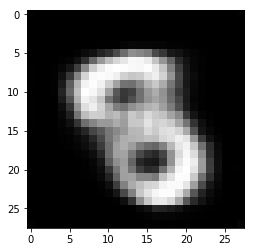

In [11]:
writer=SummaryWriter()

try:
    model = torch.load('./model/conv_VAE.pkl')
    print("\n============== Model Restored ==============\n")
except:
    print("\n============== No Model to be Restored ==============\n")
    pass

for i in range(num_epoch):
    for batch_idx,[image,_] in enumerate(train_loader):
        n_iter = (i*len(train_loader))+batch_idx
        
        x=Variable(image)
        # x: batchsize x 1 x 28 x 28
        
        optimizer.zero_grad()
        
        reconstructed_image=model(x)
        
        loss=loss_func(reconstructed_image,x,model.z_mu,model.z_logvar)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx%50==0:
            print('Training Epoch: {} \tn_iter: {} \tLoss: {:.6f}'.format(
                i, n_iter, loss.data[0]))
            
        if batch_idx%200==0:
            torch.save(model,'./model/conv_VAE_'+str(batch_idx)+'.pkl')
            torch.save(model,'./model/conv_VAE.pkl')
            
        writer.add_scalar('loss',loss.data[0] / len(x),n_iter)
        
plt.imshow(model(x).data[0].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

## Sample results

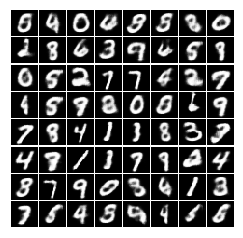

In [12]:
example_z = Variable(torch.FloatTensor(8*8*z_dim).normal_(0,1).view(64,-1))

samples = model.decoder(example_z).data.numpy()
fig = plt.figure(figsize=(4, 4))
gs = gridspec.GridSpec(8, 8)
gs.update(wspace=0.05, hspace=0.05)
for i, sample in enumerate(samples):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28, 28), cmap='Greys_r')
fig.savefig("generated_images_by_{}epochs.png".format(num_epoch))